# ENCODE bigWig analysis questions
## Yunting Ma, Cecelia Liu

Do your best to answer all parts of each question. You are encouraged to collaborate, but should turn in your own answers. 

Please limit each answer to a maximum of one markdown cell, one code cell and one plot. 

Put helper functions into a separate script (e.g. `hwutils.py`) so the notebook can be focused on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [240]:
# useful libraries to import

import pandas as pd
import numpy as np
import plotly.express as px
import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

In [288]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('data/ENCODE_GRCh38_bigWig_metadata.tsv', low_memory=False)

- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


Text(0, 0.5, 'average read')

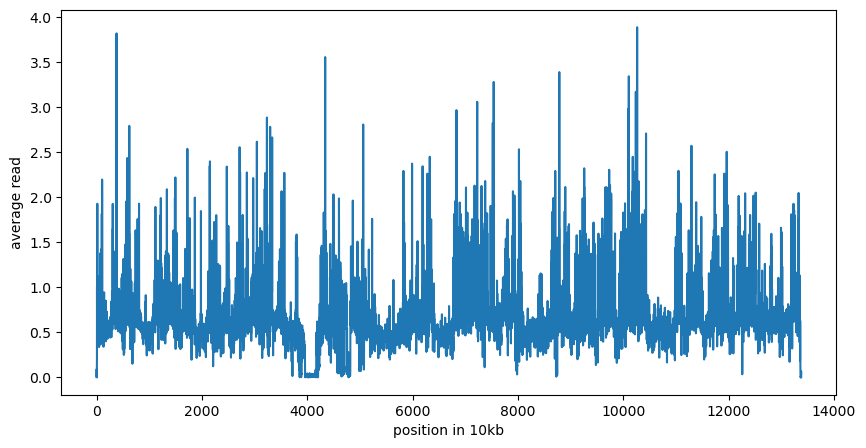

In [289]:
# plot profile
df_mean = df.iloc[:, 3:].mean(axis=1)
fig = plt.figure(figsize=(10, 5))
plt.plot(df_mean)
plt.xlabel("position in 10kb")
plt.ylabel("average read")

**A: One possible explanation is that the centromere of chr10 locates around 40mb. In pericentromeric regions the sequence are repetitive, so the alignment of the Chip-seq may fail to map correctly in that region, resulting in signal loss especially if dupllicates are removed during alignment. Since the centromere is of compact stuctures, crosslinking agents used in ChIP-seq may have reduced efficiency in compacted chromatin regions. Crosslinking may not effectively capture protein-DNA interactions within tightly packed nucleosomes or heterochromatin regions. Also, compacted chromatin can restrict access to transcription factor binding sites, histone modifications, or other epigenetic marks. Thus, ChIP-seq may not effectively capture DNA-protein interactions around centromeres.**

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


Text(0, 0.5, 'PC2')

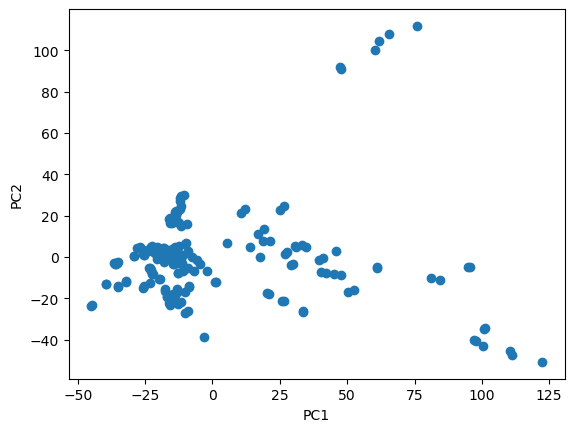

In [292]:
df_nopos = df.iloc[:, 3:]
df_transposed = df_nopos.transpose()
pca = sklearn.decomposition.PCA(n_components = 2)
pca.fit(df_transposed)
x_pca = pca.transform(df_transposed)
plt.scatter(x_pca[:,0],x_pca[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")

bigwig_metadata- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

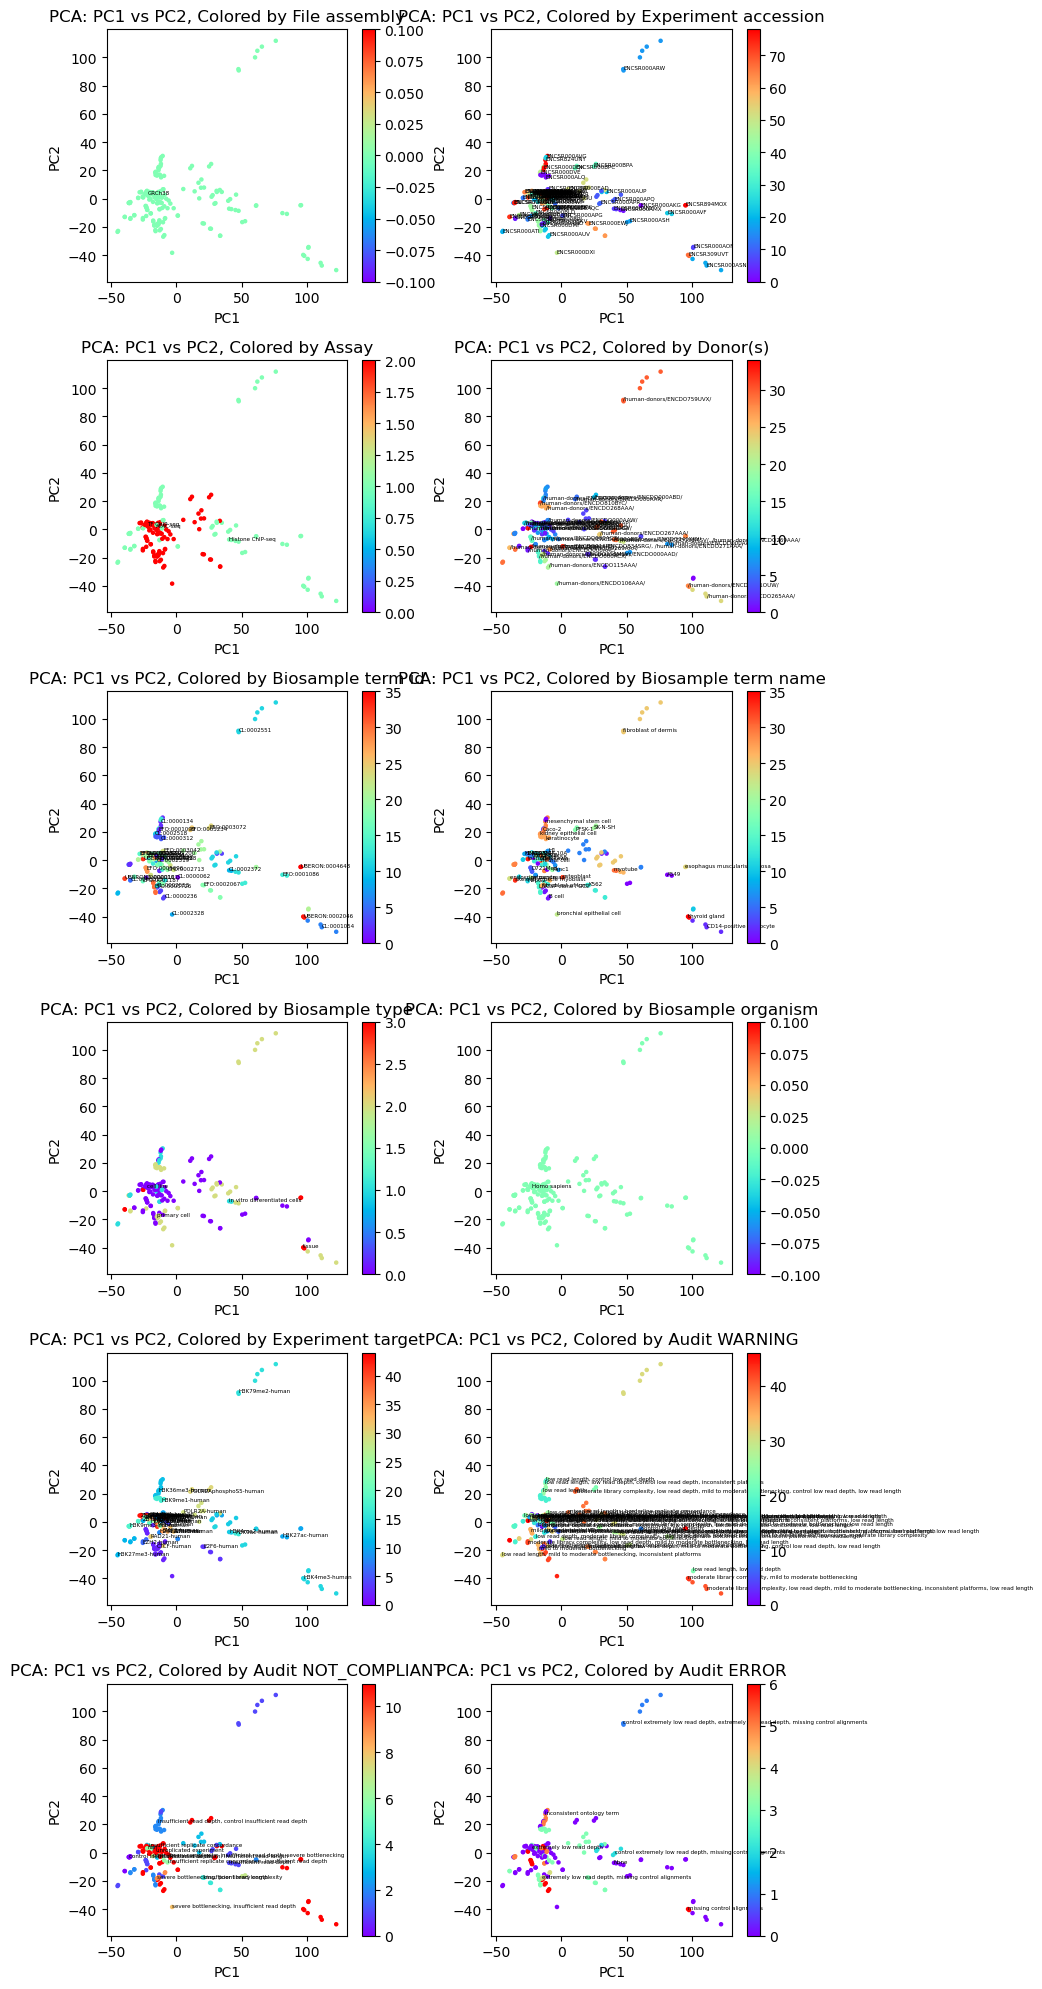

Text(0, 0.5, 'PC2')

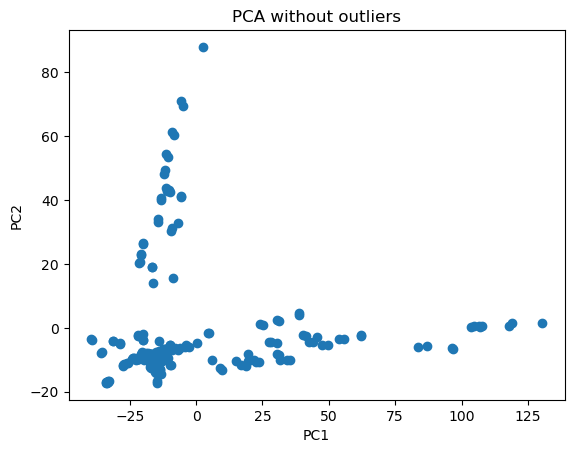

In [293]:
bigwig_metadata_ordered = bigwig_metadata.set_index('File accession').reindex(df_transposed.index)
labels = ['File assembly', 'Experiment accession', 'Assay',
       'Donor(s)', 'Biosample term id', 'Biosample term name',
       'Biosample type', 'Biosample organism','Experiment target',
          'Audit WARNING','Audit NOT_COMPLIANT','Audit ERROR']
label_encoder = sklearn.preprocessing.LabelEncoder()
fig, axes = plt.subplots(6, 2, figsize=(10,20))
axes = np.ravel(axes)
for i, feature in enumerate(labels):
    feature_values = bigwig_metadata_ordered[feature]
    feature_values_encoded = label_encoder.fit_transform(feature_values)
    ax = axes[i]
    sc = ax.scatter(x_pca[:, 0], x_pca[:, 1], c=feature_values_encoded, cmap='rainbow', s=5)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA: PC1 vs PC2, Colored by {feature}")
    plt.colorbar(sc, ax=ax)
    for idx in (np.unique(feature_values_encoded, return_index=True))[1]:
        ax.text(x_pca[idx, 0], x_pca[idx, 1], str(feature_values[idx]), fontsize=4)
plt.tight_layout()
plt.show()

#remove outlier
not_outlier = bigwig_metadata_ordered['Audit ERROR'] != 'control extremely low read depth, extremely low read depth, missing control alignments'
df_nopos = df.iloc[:, 3:]
df_transposed = df_nopos.transpose()
df_transposed = df_transposed[not_outlier]
pca = sklearn.decomposition.PCA(n_components = 2)
pca.fit(df_transposed)
x_pca = pca.transform(df_transposed)
plt.scatter(x_pca[:,0],x_pca[:,1])
plt.title("PCA without outliers")
plt.xlabel("PC1")
plt.ylabel("PC2")

**A: The samples in the upper right and lower right corners seem like outliers. Audit ERROR column clearly separates one category - control extremely low read depth, extremely low read depth, missing control alignments - to the upper right corner, so it can be referenced to remove outlier. Some columns, like the donor column and biosample term name column display the outliers in same color for each corner, so there can be some categories of the metedata are likely to be outliers, but still it is unlikely to identify the outliers just based by these metadata columns.**

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


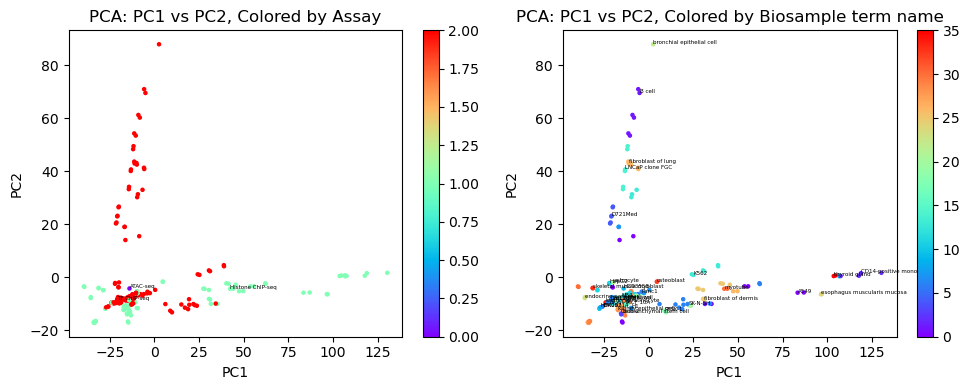

In [296]:
bigwig_metadata_ordered = bigwig_metadata.set_index('File accession').reindex(df_transposed.index)
labels = ['Assay', 'Biosample term name']
label_encoder = sklearn.preprocessing.LabelEncoder()
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes = np.ravel(axes)
for i, feature in enumerate(labels):
    feature_values = bigwig_metadata_ordered[feature]
    feature_values_encoded = label_encoder.fit_transform(feature_values)
    ax = axes[i]
    sc = ax.scatter(x_pca[:, 0], x_pca[:, 1], c=feature_values_encoded, cmap='rainbow', s=5)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA: PC1 vs PC2, Colored by {feature}")
    plt.colorbar(sc, ax=ax)
    for idx in (np.unique(feature_values_encoded, return_index=True))[1]:
        ax.text(x_pca[idx, 0], x_pca[idx, 1], str(feature_values[idx]), fontsize=4)
plt.tight_layout()
plt.show()

**A: From PCA plot, both TF Chip-seq  and histone Chip-seq shows broad patterns. There is only one sample of ATAC-seq, so it is hard to recognize any pattern for this assay.**

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


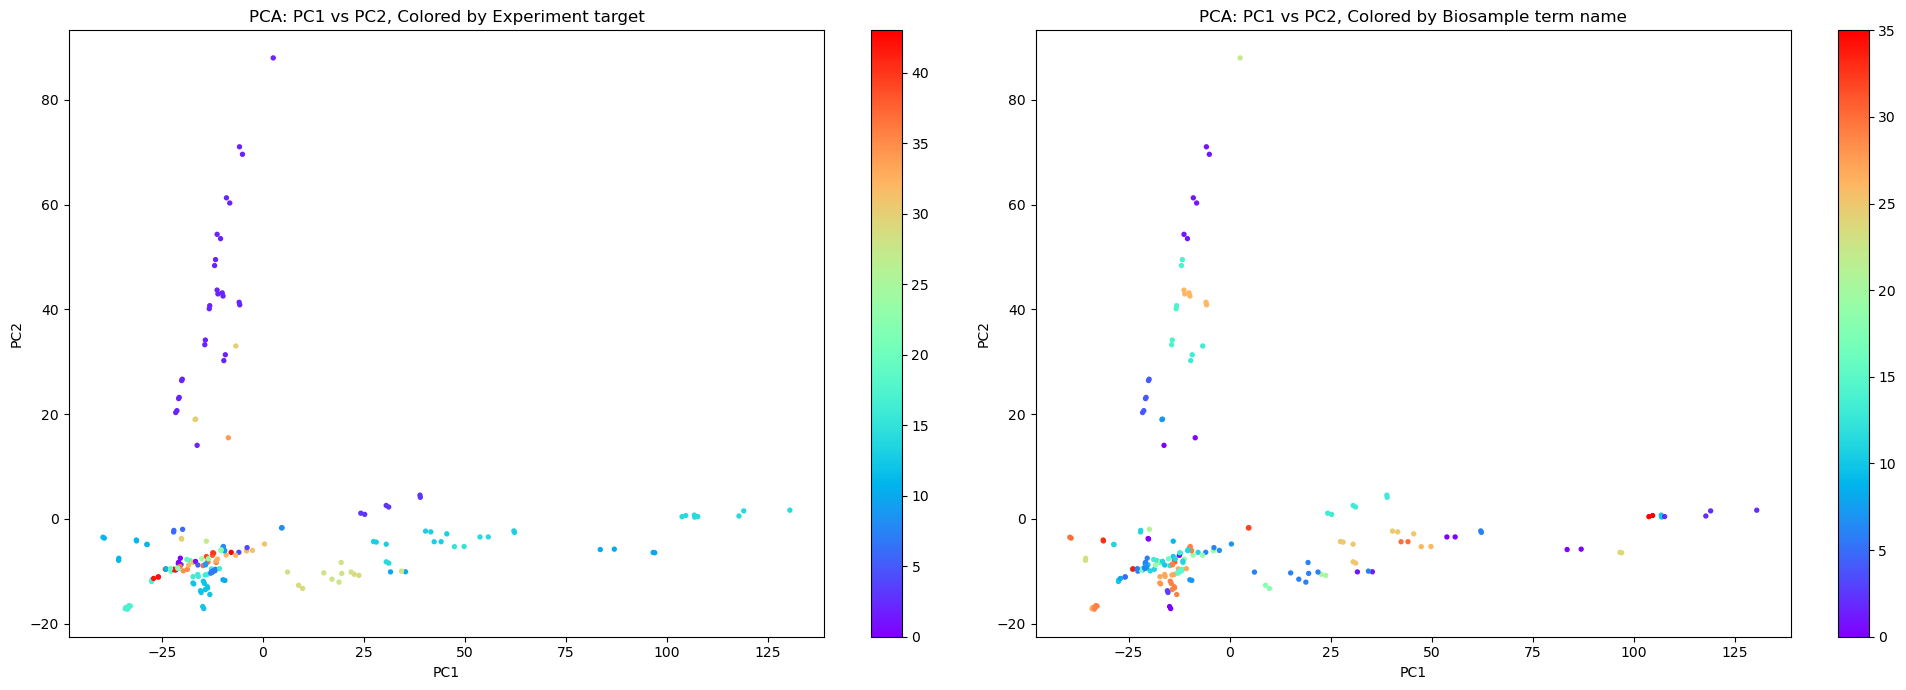

In [297]:
bigwig_metadata_ordered = bigwig_metadata.set_index('File accession').reindex(df_transposed.index)
labels = ['Experiment target', 'Biosample term name']
label_encoder = sklearn.preprocessing.LabelEncoder()
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = np.ravel(axes)
for i, feature in enumerate(labels):
    feature_values = bigwig_metadata_ordered[feature]
    feature_values_encoded = label_encoder.fit_transform(feature_values)
    ax = axes[i]
    sc = ax.scatter(x_pca[:, 0], x_pca[:, 1], c=feature_values_encoded, cmap='rainbow', s=8)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA: PC1 vs PC2, Colored by {feature}")
    plt.colorbar(sc, ax=ax)
    # for idx in (np.unique(feature_values_encoded, return_index=True))[1]:
    #     ax.text(x_pca[idx, 0], x_pca[idx, 1], str(feature_values[idx]), fontsize=6, alpha=0.8)
plt.tight_layout()
plt.show()

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


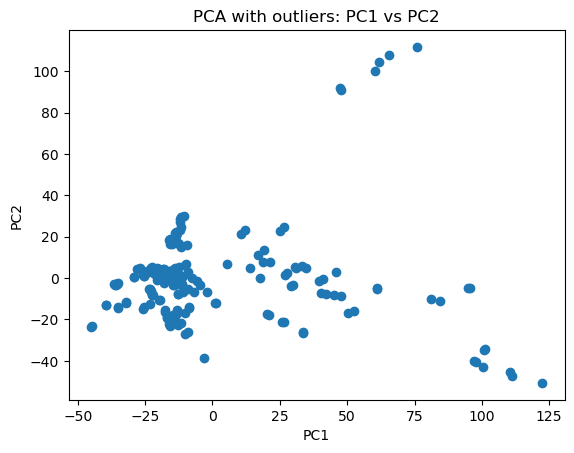

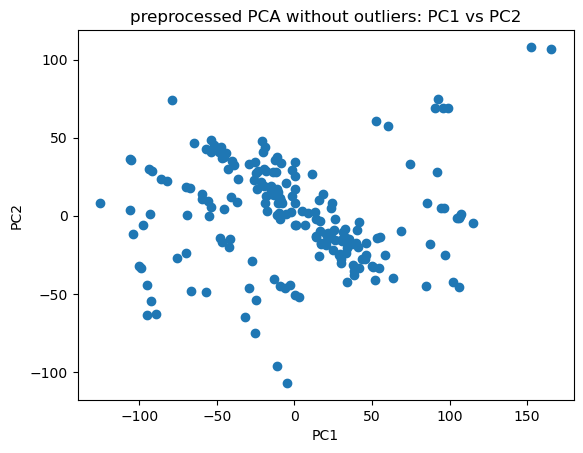

In [307]:
df_nopos = df.iloc[:, 3:]
df_transposed = df_nopos.transpose()
pca = sklearn.decomposition.PCA(n_components = 2)
pca.fit(df_transposed)
x_pca = pca.transform(df_transposed)
plt.scatter(x_pca[:,0],x_pca[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA with outliers: PC1 vs PC2")
plt.show()

df_filtered = df.drop(range(3800, 4200))
df_filtered_nopos = df_filtered.iloc[:, 3:]
df_filtered_transposed = df_filtered_nopos.transpose()
df_filtered_transposed = df_filtered_transposed[not_outlier]
scaler = sklearn.preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(df_filtered_transposed)
pca_filtered = sklearn.decomposition.PCA()
pca_filtered.fit(scaled_data)
x_pca_filtered = pca_filtered.transform(scaled_data)
plt.scatter(x_pca_filtered[:, 0], x_pca_filtered[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("preprocessed PCA without outliers: PC1 vs PC2")
plt.show()

**A: Preprocessing, in this case, removing outliers of "control extremely low read depth, extremely low read depth, missing control alignments" in aurdit-ERROR column, excluding Chip-seq signals from the peri-centromeric regions on chr10, and normalizing the scales, creates large difference between the two PCAs.**

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


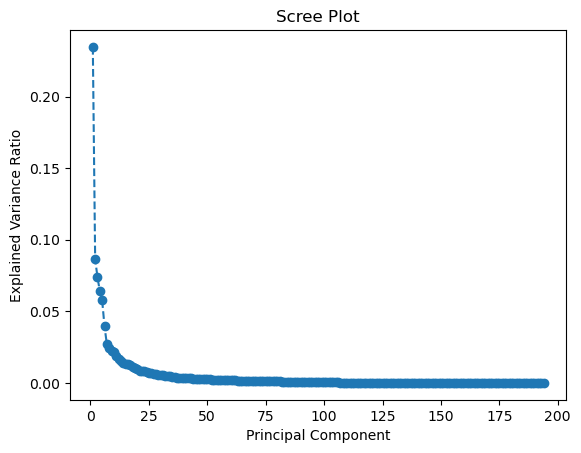

41 PCs are needed to explain 90% of the variance in the data


In [314]:
explained_variance_ratio = pca_filtered.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n = np.argmax(cumulative_variance >= 0.9) + 1
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.show()
print(n, "PCs are needed to explain 90% of the variance in the data")

- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


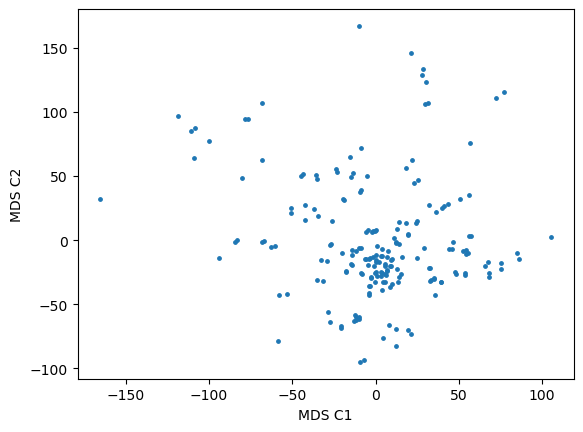

In [313]:
from sklearn.manifold import MDS

df_nopos = df.iloc[:, 3:]
df_transposed = df_nopos.transpose()
mds = MDS(random_state=0)
dft = mds.fit_transform(df_transposed)
plt.scatter(x=dft[:,0], y=dft[:,1], s=6)
plt.xlabel('MDS C1')
plt.ylabel('MDS C2')
plt.show() 

**A: MDS is different from 2D PCA in preservation of pairwise distances instead of overall variances, and may capture nonlinear relationships in the data. Distance metrics like euclidean or Manhattan distances can be computed to measure the similarity of the two methods results.**

- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


**A: Yes, non-negative matrix factorization(NMF) can be helpful. It can be applied in this case since Chip-seq signal data are non-negative. Unlike PCA, which assumes a linear relationship between variables and does linear transformation to capture data variance without explicitly separating the contribution of each feature, NMF decomposes the dataset into non-negative components and treats different features separately, and may capture the main characteristics of the dataset, which may potentially better represent the Chip-seq data over the profile.**